In [3]:
import torch
from nets import ConvDecoder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch import nn
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

In [4]:
with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/shapes_fixed_rgb8_1_10k_norm_np.pkl", 'rb') as f:
    data = pickle.load(f)

pose, img = data

In [5]:
# data preperation
batch_size = 100
train_test_ratio = 0.7

ratio_id = int(pose.shape[0] * train_test_ratio)

train_pose = pose[:ratio_id]
train_img = img[:ratio_id]
test_pose = pose[ratio_id:]
test_img = img[ratio_id:]

train_set = TensorDataset(torch.from_numpy(train_pose).float(), torch.from_numpy(train_img).float())
test_set = TensorDataset(torch.from_numpy(test_pose).float(), torch.from_numpy(test_img).float())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
print('Device: ', device)

epochs = 200

net = ConvDecoder()

net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.95)
criterion = nn.MSELoss()

train_loss_epoch = []
train_loss_total = []

test_loss_epoch = []
test_loss_total = []

for epoch in range(epochs):
    net.train()
    train_loss_batch = []
    for i, (pose, img) in enumerate(train_loader):
        pose = pose.to(device)
        img = img.to(device)

        optimizer.zero_grad()  # zero the gradient buffers
        output = net(pose)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()  # Does the update
        loss = loss.item()

        train_loss_batch.append(loss)
        train_loss_total.append(loss)

    scheduler.step()

    train_loss_epoch.append(np.mean(train_loss_batch))
    
    if epoch%1==0:
        net.eval()
        test_loss_batch = []
        for i, (pose, img) in enumerate(test_loader):
            pose = pose.to(device)
            img = img.to(device)

            optimizer.zero_grad()  # zero the gradient buffers
            output = net(pose)
            loss = criterion(output, img)
            loss = loss.item()

            test_loss_batch.append(loss)
            test_loss_total.append(loss)
        
        test_loss_epoch.append(np.mean(test_loss_batch))

        print('------ Epoch ', epoch)
        print('Epoch loss:', train_loss_epoch[-1])
        print('Val loss:', test_loss_epoch[-1])
        torch.save(net.state_dict(), "deconv_shapes_fixed_2_200e.pt")

Device:  cuda
------ Epoch  0
Epoch loss: 0.11101305218679565
Val loss: 0.05279571982721488
------ Epoch  1
Epoch loss: 0.05050622522830963
Val loss: 0.03927965292086204
------ Epoch  2
Epoch loss: 0.037418650782534056
Val loss: 0.031425043965379394
------ Epoch  3
Epoch loss: 0.03199608629303319
Val loss: 0.02680653965100646
------ Epoch  4
Epoch loss: 0.026927280931600503
Val loss: 0.021814036772896846
------ Epoch  5
Epoch loss: 0.020221103541553022
Val loss: 0.014779813004036744
------ Epoch  6
Epoch loss: 0.01616682553929942
Val loss: 0.012636438099046549
------ Epoch  7
Epoch loss: 0.014419064630887338
Val loss: 0.011361412294209004
------ Epoch  8
Epoch loss: 0.0132593134551176
Val loss: 0.010663327621296048
------ Epoch  9
Epoch loss: 0.012595701483743532
Val loss: 0.010043293858567873
------ Epoch  10
Epoch loss: 0.011823033035865852
Val loss: 0.009460362096627553
------ Epoch  11
Epoch loss: 0.011253018105136497
Val loss: 0.00925635324480633
------ Epoch  12
Epoch loss: 0.010

KeyboardInterrupt: 

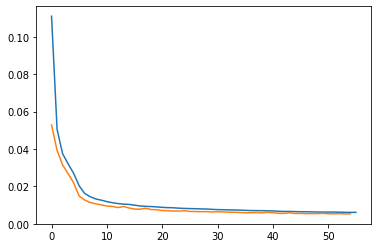

In [8]:
plt.plot(range(len(train_loss_epoch)), train_loss_epoch)
plt.plot(range(len(test_loss_epoch)), test_loss_epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.97798624 0.2448112 ]
1.2326436


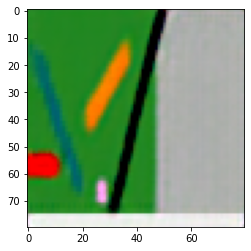

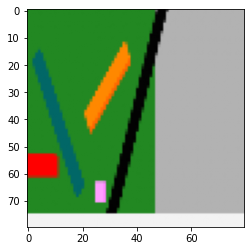

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.36685428 0.7723806 ]
1.1413777


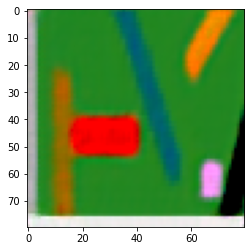

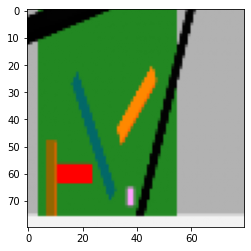

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.77542214 0.30976494]
1.1611773


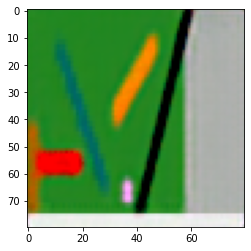

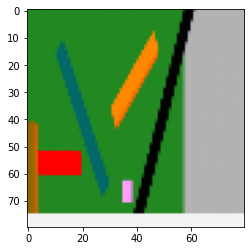

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.66541588 0.18723431]
1.1091278


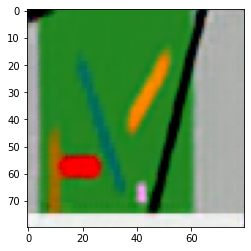

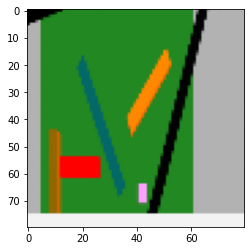

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.86166354 0.32614404]
1.1977638


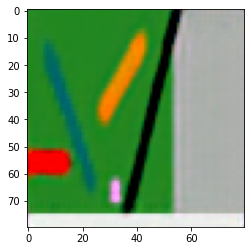

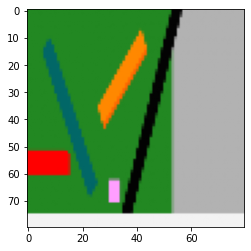

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.59906191 0.9928107 ]
1.1734394


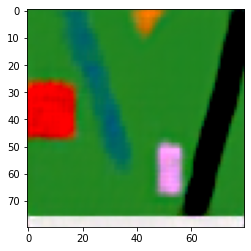

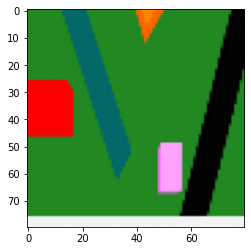

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.4727955  0.34146037]
1.1653315


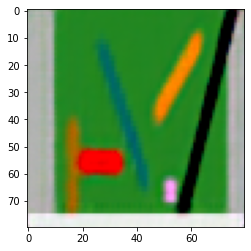

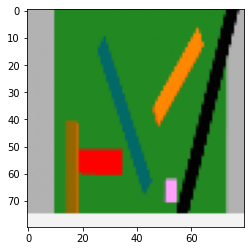

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.17767355 0.69886222]
1.1980597


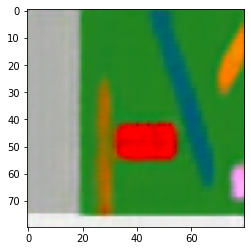

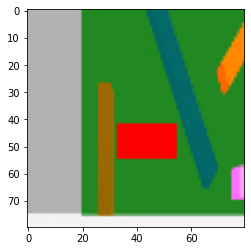

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.18993121 0.84277319]
1.2214973


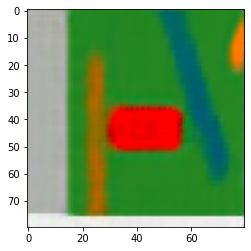

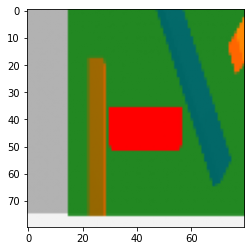

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.39631019 0.34996249]
1.2066487


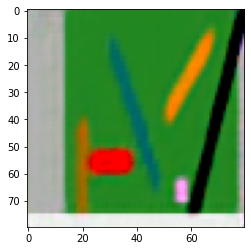

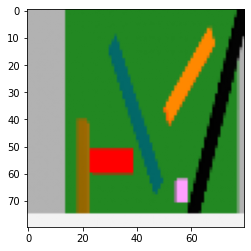

In [11]:
net.eval()
for i in random.sample(range(len(test_pose)), 10):
    print(test_pose[i])
    pred = net(torch.tensor(test_pose[i]).unsqueeze(0).unsqueeze(1).float().cuda()).cpu().detach().numpy().squeeze().transpose(1,2,0)
    print(np.max(pred))
    plt.imshow(pred)
    plt.show()
    plt.imshow(test_img[i].transpose(1,2,0))
    plt.show()